In [1]:
import os,sys
sys.path.insert(1, os.path.join(os.getcwd()  , '..'))
import shallowsim as sb
import pandas as pd
import math
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
args = sb.ModelArgs()
c = sb.Config()

In [3]:
gpu_all_decode = sb.get_gpu_info('./device/gpu_info.csv',decoding_mode=True) 

# generate data
'''
dfs = []
for seq_len in range(1024,16384,32):
    c.seq_len = seq_len
    df = sb.decode_time_with_ep_list(args,gpu_all_decode,c,fp8_combine=True)
    df['Seq_len'] = seq_len
    df_o = df.groupby(['GPU','BatchSize','EP'],as_index=False).apply(lambda t: t[t.Total==t.Total.max()]).sort_values(['Total'],ascending=False).reset_index(drop=True)
    df_o.drop_duplicates(subset=['GPU','BatchSize','EP'], keep='first', inplace=True)
    dfs.append(df_o)
df = pd.concat(dfs)    
df.reset_index(inplace=True,drop=True)
df.to_csv('perf_vs_seq_len.csv')
'''

"\ndfs = []\nfor seq_len in range(1024,16384,32):\n    c.seq_len = seq_len\n    df = sb.decode_time_with_ep_list(args,gpu_all_decode,c,fp8_combine=True)\n    df['Seq_len'] = seq_len\n    df_o = df.groupby(['GPU','BatchSize','EP'],as_index=False).apply(lambda t: t[t.Total==t.Total.max()]).sort_values(['Total'],ascending=False).reset_index(drop=True)\n    df_o.drop_duplicates(subset=['GPU','BatchSize','EP'], keep='first', inplace=True)\n    dfs.append(df_o)\ndf = pd.concat(dfs)    \ndf.reset_index(inplace=True,drop=True)\ndf.to_csv('perf_vs_seq_len.csv')\n"

In [38]:
df = pd.read_csv('perf_vs_seq_len.csv')
df['BatchSize']= df['BatchSize'].astype(int).astype(str)

In [39]:
df1 = df[df['EP'] == 144].reset_index(drop=True)

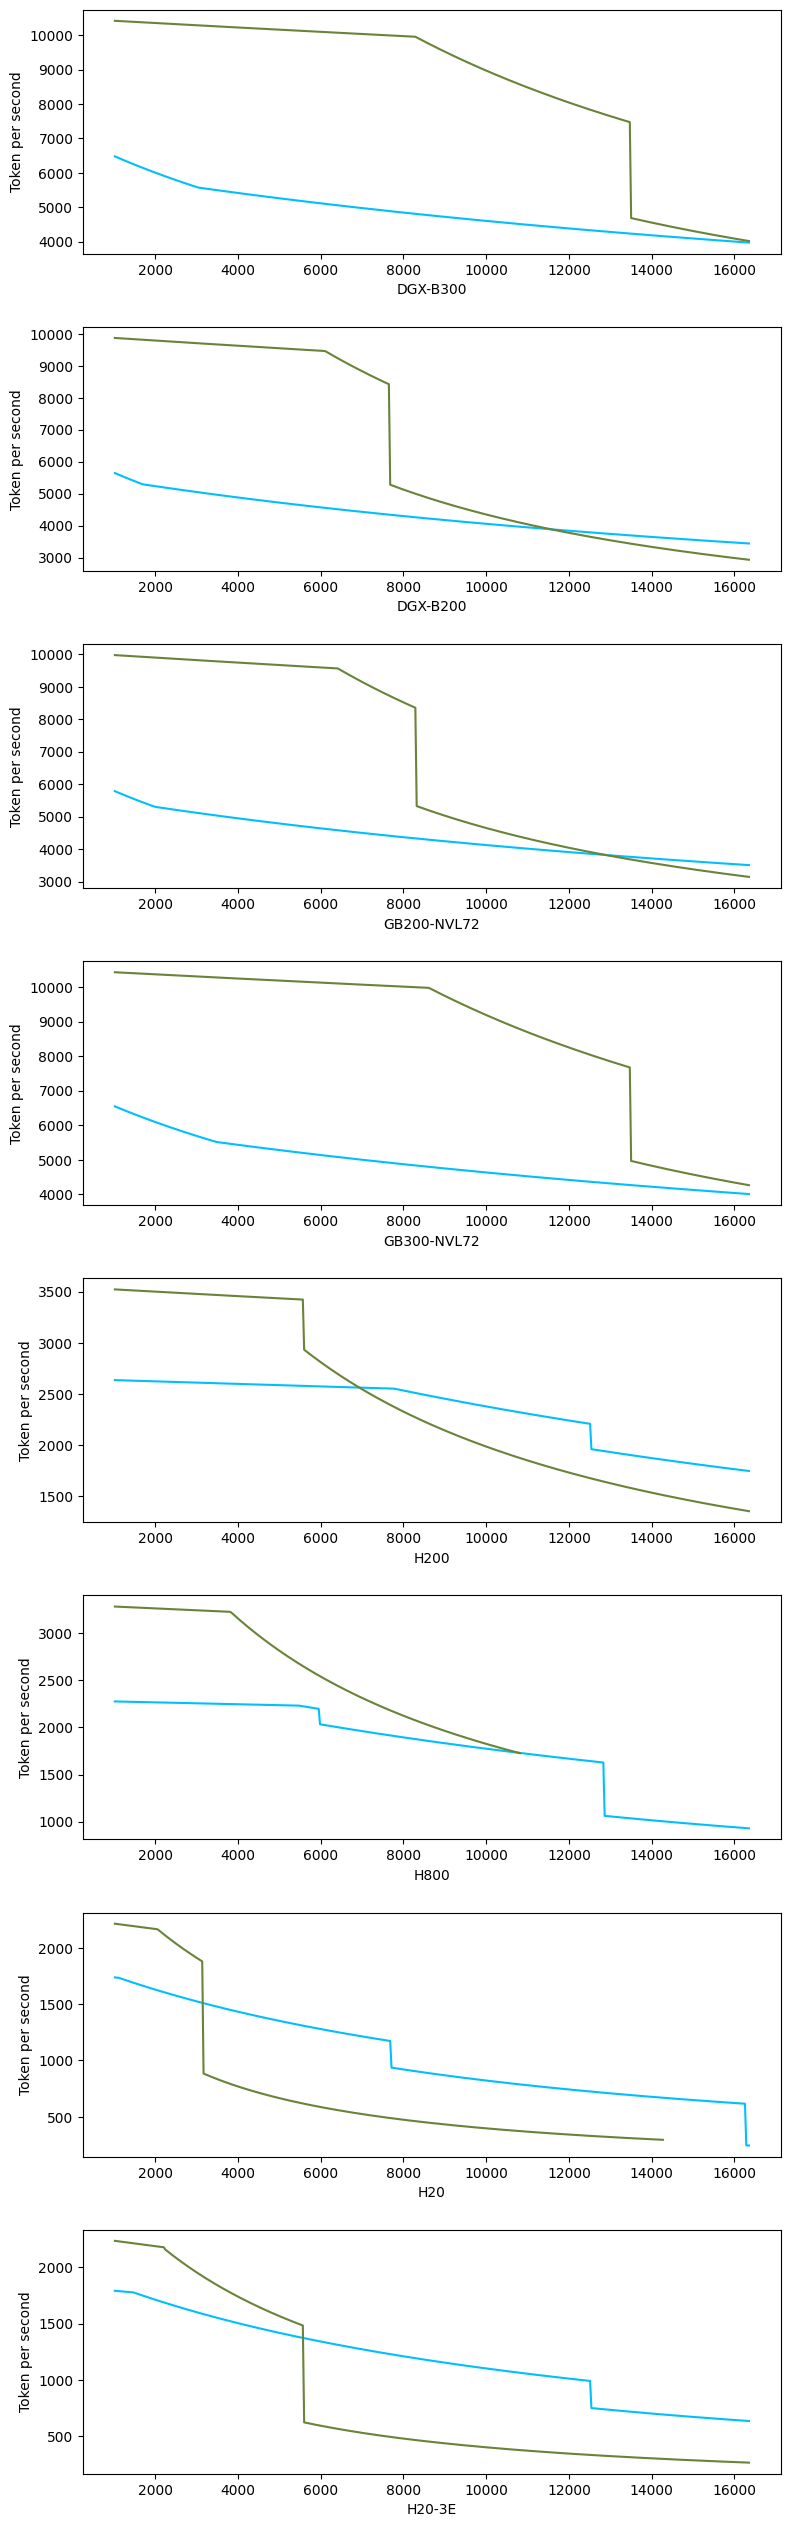

In [41]:
sb.draw(df1, gpu_all_decode, 'Total','Token per second')